In [1]:
import numpy as np
import tensorflow as tf

import sys
sys.path.append("..")
from dgp import DGP_RF
from likelihoods import Gaussian
# from utils_dataset import load_UCI_dataset
from utils import cyclical_lr_schedule

from matplotlib import pyplot as plt

In [2]:
class ToyRegressionDGP(DGP_RF):
    def __init__(self, d_in, d_out, n_hidden_layers=1, n_rf=20, n_gp=2, likelihood=Gaussian(),
                 kernel_type_list=None, random_fixed=True, input_cat=False, set_nonzero_mean=False, name=None):
        super(ToyRegressionDGP, self).__init__(d_in, d_out, n_hidden_layers=n_hidden_layers,
                                            n_rf=n_rf, n_gp=n_gp, likelihood=likelihood,
                                            kernel_type_list=kernel_type_list, random_fixed=random_fixed,
                                            input_cat=input_cat,set_nonzero_mean=set_nonzero_mean, name=name)

    def feed_forward(self, ds):
        out_before_likelihood = []
        for x_batch, y_batch in ds:
            x_batch = tf.constant(x_batch, tf.float32)
            # output mean because of the Gaussian likelihood in the final layer
            out_before_likelihood.append(self.BNN(x_batch))
        out_before_likelihood = tf.concat(out_before_likelihood, axis=0)
        return out_before_likelihood

    def feed_forward_all_layers(self, X):
        layer_output_list = []
        for l, layer in enumerate(self.BNN.layers):
            X = layer(X)
            if l % 2 == 1:
                layer_output_list.append(X)
        return layer_output_list

    def eval_log_likelihood_and_se(self, ds):
        """
        :param ds:iterable X: [N, D_in]; Y: [N, D_out];
        :return: output matrix of log likelihood log p(Y|F), shape [N, ] and square errors [N, ]
        """
        log_p_all_data = []
        se_all_data = []
        for x_batch, y_batch in ds:
            out_before_likelihood = self.BNN(x_batch)
            log_p_batch = self.likelihood.log_prob(out_before_likelihood, y_batch)
            log_p_all_data.append(log_p_batch)
            assert isinstance(self.likelihood, Gaussian), "The likelihood of the model is not Gaussian!"
            ### redce_sum???
            se_batch = tf.reduce_mean(tf.square(y_batch - out_before_likelihood), axis=-1)
            se_all_data.append(se_batch)
        log_p_all_data = tf.concat(log_p_all_data, axis=0)
        se_all_data = tf.concat(se_all_data, axis=0)
        return log_p_all_data, se_all_data

Metal device set to: Apple M1 Pro


2022-06-28 00:48:50.361373: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-28 00:48:50.361547: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# sin function fitting

In [3]:
def get_sin_data(num_training, num_testing, std_noise=0.1):
    X_train = np.random.uniform(-1.5, 1.5, num_training)
    Y_train = np.sin(np.pi * X_train) + np.random.randn(num_training) * std_noise
    X_train = np.reshape(X_train, [num_training, 1])
    Y_train = np.reshape(Y_train, [num_training, 1])

    X_test = np.linspace(-2., 2., num_testing)[:, None]
    Y_test = np.sin(np.pi * X_test)
    return np.float32(X_train), np.float32(Y_train), np.float32(X_test), np.float32(Y_test)

def load_demo_data(num_training, num_testing, std_noise=0.1):
    X_train, Y_train, X_test, Y_test= get_sin_data(num_training, num_testing, std_noise=std_noise)
    ds_X_train = tf.data.Dataset.from_tensor_slices(X_train)
    ds_Y_train = tf.data.Dataset.from_tensor_slices(Y_train)
    ds_train = tf.data.Dataset.zip((ds_X_train, ds_Y_train))
    ds_X_test = tf.data.Dataset.from_tensor_slices(X_test)
    ds_Y_test = tf.data.Dataset.from_tensor_slices(Y_test)
    ds_test = tf.data.Dataset.zip((ds_X_test, ds_Y_test))

    ds_train = ds_train.shuffle(num_training)
    # ds_test = ds_test.shuffle(num_testing)
    ds_train = ds_train.batch(num_training)
    ds_test = ds_test.batch(num_testing)
    return ds_train, ds_test

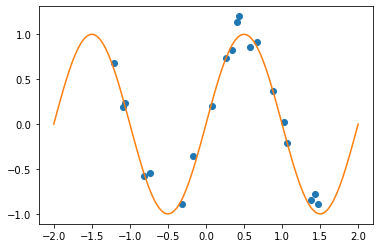

In [4]:
num_training = 20
num_testing = 100
std_noise = 0.1

ds_train, ds_test = load_demo_data(num_training, num_testing, std_noise=std_noise)
for x, y in ds_train:
    plt.plot(x[:,0], y[:,0], 'o', label='training points')
for x, y in ds_test:
    plt.plot(x[:,0], y[:,0], label='ground truth')

## 2-layer DGPs

In [5]:
# batch_size = 128
# ds_train, ds_test, train_shape, test_shape = load_UCI_dataset('boston', batch_size=batch_size, transform_fn=None,
#                                                                       data_dir='./data/')
for X_test, _ in ds_test:
    break
ds_M = ds_train
model = ToyRegressionDGP(1, 1, n_hidden_layers=2, n_rf=500, n_gp=[50, 1], likelihood=Gaussian(),
                          kernel_type_list=['RBF', 'RBF'], random_fixed=True, set_nonzero_mean=False, input_cat=False)

total_epoches = 10000
start_sampling = 1000
lr_0 = 0.1
beta = 0.98
cycle_length = 50

2022-06-28 00:48:58.188274: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


In [6]:
log_p = []
mse = []
lines = []
for epoch in range(total_epoches):
    model.precond_update(ds_M, num_training, K_batches=32, precond_type='rmsprop', rho_rms=0.99)
    for img_batch, label_batch in ds_train:
        if epoch < start_sampling: # fixed learning rate, zero temperature
            model.sgmcmc_update(img_batch, label_batch, num_training,
                                lr=lr_0, beta=beta, temperature=0.)
        else: # cyclical learning rate, non-zero temperature
            lr = cyclical_lr_schedule(lr_0, epoch - start_sampling, cycle_length)
            model.sgmcmc_update(img_batch, label_batch, num_training,
                                lr=lr, beta=beta, temperature=1.)

    if epoch < start_sampling:
        lr_current = lr_0
    else:
        lr_current = lr
    if (epoch + 1) % 100 == 0:
        train_log_p, train_se = model.eval_log_likelihood_and_se(ds_train)
        print(f"On training data, Epoch: {epoch},  lr: {lr_current}, ",
              f"Total log likelihood: {tf.reduce_mean(train_log_p)},  ",
              f"Total MSE: {tf.reduce_mean(train_se)}; ")
        test_log_p, test_se = model.eval_log_likelihood_and_se(ds_test)
        print(f"On test data, Epoch: {epoch},  lr: {lr_current}, ",
              f"Total log likelihood: {tf.reduce_mean(test_log_p)},  ",
              f"Total MSE: {tf.reduce_mean(test_se)}; ")
        print(" ")

    if epoch >= start_sampling:
        if (epoch - start_sampling) % cycle_length == cycle_length - 1:
            test_log_p, test_se = model.eval_log_likelihood_and_se(ds_test)
            print("#"*20, " Sampling the model ", "#"*20)
            print(f"On test data, Epoch: {epoch},  lr: {lr_current}, ",
                  f"Total log likelihood: {tf.reduce_mean(test_log_p)},  ",
                  f"Total MSE: {tf.reduce_mean(test_se)}; ")
            print(" ")
            log_p.append(test_log_p)
            mse.append(test_se)

            line_sample = model.feed_forward_all_layers(X_test)
            lines.append(line_sample)

log_p = tf.stack(log_p, axis=0) # [S, N]
mse = tf.stack(mse, axis=0) #[S, N]

n_models = tf.cast(tf.shape(mse)[0], tf.float32)
predict_log_p = tf.reduce_logsumexp(log_p, axis=0) - tf.math.log(n_models)
predict_log_p = tf.reduce_mean(predict_log_p)
predict_rmse = tf.math.sqrt(tf.reduce_mean(mse))

print(f"Number of sampling models: {tf.shape(mse)[0]} ")
print(f"Test log likelihood of sampling models: {predict_log_p}")
print(f"Test Root MSE: {predict_rmse}")

On training data, Epoch: 99,  lr: 0.1,  Total log likelihood: -0.031488750129938126,   Total MSE: 0.05276856571435928; 
On test data, Epoch: 99,  lr: 0.1,  Total log likelihood: -0.3090848922729492,   Total MSE: 0.10828778147697449; 
 
On training data, Epoch: 199,  lr: 0.1,  Total log likelihood: -0.3966054916381836,   Total MSE: 0.12579190731048584; 
On test data, Epoch: 199,  lr: 0.1,  Total log likelihood: -0.812741756439209,   Total MSE: 0.20901915431022644; 
 
On training data, Epoch: 299,  lr: 0.1,  Total log likelihood: -0.5207587480545044,   Total MSE: 0.15062254667282104; 
On test data, Epoch: 299,  lr: 0.1,  Total log likelihood: -0.9876301288604736,   Total MSE: 0.24399684369564056; 
 
On training data, Epoch: 399,  lr: 0.1,  Total log likelihood: -0.48549723625183105,   Total MSE: 0.14357025921344757; 
On test data, Epoch: 399,  lr: 0.1,  Total log likelihood: -1.040968418121338,   Total MSE: 0.25466448068618774; 
 
On training data, Epoch: 499,  lr: 0.1,  Total log likeli

####################  Sampling the model  ####################
On test data, Epoch: 1949,  lr: 9.866357140708715e-05,  Total log likelihood: -0.45877477526664734,   Total MSE: 0.13822577893733978; 
 
On training data, Epoch: 1999,  lr: 9.866357140708715e-05,  Total log likelihood: -0.13270317018032074,   Total MSE: 0.07301145046949387; 
On test data, Epoch: 1999,  lr: 9.866357140708715e-05,  Total log likelihood: -1.1691945791244507,   Total MSE: 0.2803097069263458; 
 
####################  Sampling the model  ####################
On test data, Epoch: 1999,  lr: 9.866357140708715e-05,  Total log likelihood: -1.1691945791244507,   Total MSE: 0.2803097069263458; 
 
####################  Sampling the model  ####################
On test data, Epoch: 2049,  lr: 9.866357140708715e-05,  Total log likelihood: -0.7811073064804077,   Total MSE: 0.20269230008125305; 
 
On training data, Epoch: 2099,  lr: 9.866357140708715e-05,  Total log likelihood: 0.03477651625871658,   Total MSE: 0.03951551765

On training data, Epoch: 3199,  lr: 9.866357140708715e-05,  Total log likelihood: -0.0513714924454689,   Total MSE: 0.05674511194229126; 
On test data, Epoch: 3199,  lr: 9.866357140708715e-05,  Total log likelihood: -1.232362985610962,   Total MSE: 0.29294338822364807; 
 
####################  Sampling the model  ####################
On test data, Epoch: 3199,  lr: 9.866357140708715e-05,  Total log likelihood: -1.232362985610962,   Total MSE: 0.29294338822364807; 
 
####################  Sampling the model  ####################
On test data, Epoch: 3249,  lr: 9.866357140708715e-05,  Total log likelihood: -0.3673054277896881,   Total MSE: 0.1199318990111351; 
 
On training data, Epoch: 3299,  lr: 9.866357140708715e-05,  Total log likelihood: 0.02422809600830078,   Total MSE: 0.04162520170211792; 
On test data, Epoch: 3299,  lr: 9.866357140708715e-05,  Total log likelihood: -0.3668574094772339,   Total MSE: 0.1198422983288765; 
 
####################  Sampling the model  ################

####################  Sampling the model  ####################
On test data, Epoch: 4449,  lr: 9.866357140708715e-05,  Total log likelihood: -0.15653279423713684,   Total MSE: 0.07777737081050873; 
 
On training data, Epoch: 4499,  lr: 9.866357140708715e-05,  Total log likelihood: -0.0883844643831253,   Total MSE: 0.0641477108001709; 
On test data, Epoch: 4499,  lr: 9.866357140708715e-05,  Total log likelihood: -1.1713531017303467,   Total MSE: 0.280741423368454; 
 
####################  Sampling the model  ####################
On test data, Epoch: 4499,  lr: 9.866357140708715e-05,  Total log likelihood: -1.1713531017303467,   Total MSE: 0.280741423368454; 
 
####################  Sampling the model  ####################
On test data, Epoch: 4549,  lr: 9.866357140708715e-05,  Total log likelihood: -1.1777335405349731,   Total MSE: 0.2820174992084503; 
 
On training data, Epoch: 4599,  lr: 9.866357140708715e-05,  Total log likelihood: 0.13099662959575653,   Total MSE: 0.0202714949846267

On training data, Epoch: 5699,  lr: 9.866357140708715e-05,  Total log likelihood: 0.05428887531161308,   Total MSE: 0.0356130413711071; 
On test data, Epoch: 5699,  lr: 9.866357140708715e-05,  Total log likelihood: -0.7104670405387878,   Total MSE: 0.18856419622898102; 
 
####################  Sampling the model  ####################
On test data, Epoch: 5699,  lr: 9.866357140708715e-05,  Total log likelihood: -0.7104670405387878,   Total MSE: 0.18856419622898102; 
 
####################  Sampling the model  ####################
On test data, Epoch: 5749,  lr: 9.866357140708715e-05,  Total log likelihood: -0.6230291724205017,   Total MSE: 0.17107664048671722; 
 
On training data, Epoch: 5799,  lr: 9.866357140708715e-05,  Total log likelihood: 0.048152681440114975,   Total MSE: 0.0368402823805809; 
On test data, Epoch: 5799,  lr: 9.866357140708715e-05,  Total log likelihood: -0.8316418528556824,   Total MSE: 0.21279916167259216; 
 
####################  Sampling the model  #############

####################  Sampling the model  ####################
On test data, Epoch: 6949,  lr: 9.866357140708715e-05,  Total log likelihood: -1.0639948844909668,   Total MSE: 0.2592697739601135; 
 
On training data, Epoch: 6999,  lr: 9.866357140708715e-05,  Total log likelihood: -0.31700196862220764,   Total MSE: 0.10987120866775513; 
On test data, Epoch: 6999,  lr: 9.866357140708715e-05,  Total log likelihood: -1.0002361536026,   Total MSE: 0.24651801586151123; 
 
####################  Sampling the model  ####################
On test data, Epoch: 6999,  lr: 9.866357140708715e-05,  Total log likelihood: -1.0002361536026,   Total MSE: 0.24651801586151123; 
 
####################  Sampling the model  ####################
On test data, Epoch: 7049,  lr: 9.866357140708715e-05,  Total log likelihood: -0.14073316752910614,   Total MSE: 0.07461745291948318; 
 
On training data, Epoch: 7099,  lr: 9.866357140708715e-05,  Total log likelihood: 0.06479722261428833,   Total MSE: 0.0335113741457462

On training data, Epoch: 8199,  lr: 9.866357140708715e-05,  Total log likelihood: -0.06764645129442215,   Total MSE: 0.06000010296702385; 
On test data, Epoch: 8199,  lr: 9.866357140708715e-05,  Total log likelihood: -0.9946344494819641,   Total MSE: 0.24539770185947418; 
 
####################  Sampling the model  ####################
On test data, Epoch: 8199,  lr: 9.866357140708715e-05,  Total log likelihood: -0.9946344494819641,   Total MSE: 0.24539770185947418; 
 
####################  Sampling the model  ####################
On test data, Epoch: 8249,  lr: 9.866357140708715e-05,  Total log likelihood: -2.2000691890716553,   Total MSE: 0.4864845871925354; 
 
On training data, Epoch: 8299,  lr: 9.866357140708715e-05,  Total log likelihood: -0.0021941126324236393,   Total MSE: 0.0469096377491951; 
On test data, Epoch: 8299,  lr: 9.866357140708715e-05,  Total log likelihood: -0.25922173261642456,   Total MSE: 0.09831514954566956; 
 
####################  Sampling the model  #########

####################  Sampling the model  ####################
On test data, Epoch: 9449,  lr: 9.866357140708715e-05,  Total log likelihood: -1.2542273998260498,   Total MSE: 0.2973162829875946; 
 
On training data, Epoch: 9499,  lr: 9.866357140708715e-05,  Total log likelihood: 0.09956952929496765,   Total MSE: 0.026556912809610367; 
On test data, Epoch: 9499,  lr: 9.866357140708715e-05,  Total log likelihood: -0.670011579990387,   Total MSE: 0.18047313392162323; 
 
####################  Sampling the model  ####################
On test data, Epoch: 9499,  lr: 9.866357140708715e-05,  Total log likelihood: -0.670011579990387,   Total MSE: 0.18047313392162323; 
 
####################  Sampling the model  ####################
On test data, Epoch: 9549,  lr: 9.866357140708715e-05,  Total log likelihood: -0.4971539080142975,   Total MSE: 0.1459016054868698; 
 
On training data, Epoch: 9599,  lr: 9.866357140708715e-05,  Total log likelihood: 0.06538872420787811,   Total MSE: 0.03339307382702

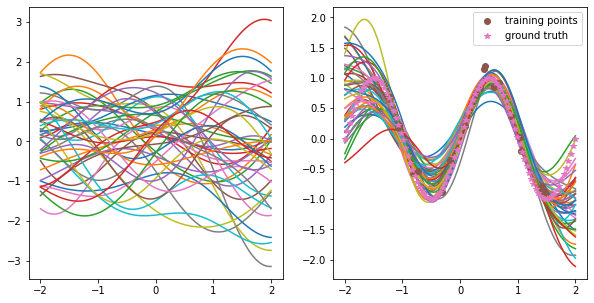

In [7]:
fig, ax = plt.subplots(1, model.n_hidden_layers, figsize=(10,5))
for i in range(model.n_hidden_layers):
    for line_sample in lines[0:45]:
        line = line_sample[i]
        ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0])
for X_train, Y_train in ds_train:
    break
    
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
for x, y in ds_test:
    ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-1].legend()

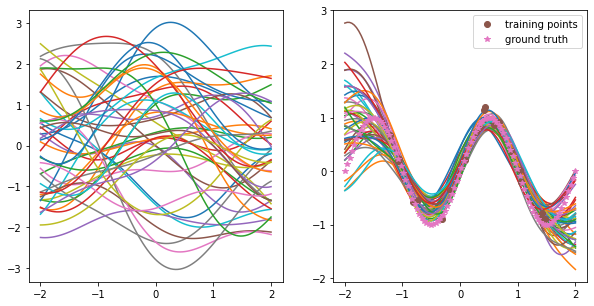

In [8]:
fig, ax = plt.subplots(1, model.n_hidden_layers, figsize=(10,5))
for i in range(model.n_hidden_layers):
    for line_sample in lines[45:90]: # subsets of sampled models
        line = line_sample[i]
        ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0])
for X_train, Y_train in ds_train:
    break
    
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
for x, y in ds_test:
    ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-1].legend()

## 3-layer DGPs

In [10]:
# batch_size = 128
# ds_train, ds_test, train_shape, test_shape = load_UCI_dataset('boston', batch_size=batch_size, transform_fn=None,
#                                                                       data_dir='./data/')
for X_test, _ in ds_test:
    break
ds_M = ds_train
model = ToyRegressionDGP(1, 1, n_hidden_layers=3, n_rf=500, n_gp=[50, 50, 1], likelihood=Gaussian(),
                          kernel_type_list=['RBF', 'RBF','RBF'], random_fixed=True, set_nonzero_mean=False, input_cat=False)

total_epoches = 10000
start_sampling = 1000
lr_0 = 0.1
beta = 0.98
cycle_length = 50

In [ ]:
log_p = []
mse = []
lines = []
for epoch in range(total_epoches):
    model.precond_update(ds_M, num_training, K_batches=32, precond_type='rmsprop', rho_rms=0.99)
    for img_batch, label_batch in ds_train:
        if epoch < start_sampling: # fixed learning rate, zero temperature
            model.sgmcmc_update(img_batch, label_batch, num_training,
                                lr=lr_0, beta=beta, temperature=0.)
        else: # cyclical learning rate, non-zero temperature
            lr = cyclical_lr_schedule(lr_0, epoch - start_sampling, cycle_length)
            model.sgmcmc_update(img_batch, label_batch, num_training,
                                lr=lr, beta=beta, temperature=1.)

    if epoch < start_sampling:
        lr_current = lr_0
    else:
        lr_current = lr
    if (epoch + 1) % 100 == 0:
        train_log_p, train_se = model.eval_log_likelihood_and_se(ds_train)
        print(f"On training data, Epoch: {epoch},  lr: {lr_current}, ",
              f"Total log likelihood: {tf.reduce_mean(train_log_p)},  ",
              f"Total MSE: {tf.reduce_mean(train_se)}; ")
        test_log_p, test_se = model.eval_log_likelihood_and_se(ds_test)
        print(f"On test data, Epoch: {epoch},  lr: {lr_current}, ",
              f"Total log likelihood: {tf.reduce_mean(test_log_p)},  ",
              f"Total MSE: {tf.reduce_mean(test_se)}; ")
        print(" ")

    if epoch >= start_sampling:
        if (epoch - start_sampling) % cycle_length == cycle_length - 1:
            test_log_p, test_se = model.eval_log_likelihood_and_se(ds_test)
            print("#"*20, " Sampling the model ", "#"*20)
            print(f"On test data, Epoch: {epoch},  lr: {lr_current}, ",
                  f"Total log likelihood: {tf.reduce_mean(test_log_p)},  ",
                  f"Total MSE: {tf.reduce_mean(test_se)}; ")
            print(" ")
            log_p.append(test_log_p)
            mse.append(test_se)

            line_sample = model.feed_forward_all_layers(X_test)
            lines.append(line_sample)

log_p = tf.stack(log_p, axis=0) # [S, N]
mse = tf.stack(mse, axis=0) #[S, N]

n_models = tf.cast(tf.shape(mse)[0], tf.float32)
predict_log_p = tf.reduce_logsumexp(log_p, axis=0) - tf.math.log(n_models)
predict_log_p = tf.reduce_mean(predict_log_p)
predict_rmse = tf.math.sqrt(tf.reduce_mean(mse))

print(f"Number of sampling models: {tf.shape(mse)[0]} ")
print(f"Test log likelihood of sampling models: {predict_log_p}")
print(f"Test Root MSE: {predict_rmse}")

On training data, Epoch: 99,  lr: 0.1,  Total log likelihood: -0.05192170292139053,   Total MSE: 0.05685516074299812; 
On test data, Epoch: 99,  lr: 0.1,  Total log likelihood: -0.5305820107460022,   Total MSE: 0.15258720517158508; 
 
On training data, Epoch: 199,  lr: 0.1,  Total log likelihood: -0.5296733975410461,   Total MSE: 0.1524054855108261; 
On test data, Epoch: 199,  lr: 0.1,  Total log likelihood: -0.9433451890945435,   Total MSE: 0.23513981699943542; 
 
On training data, Epoch: 299,  lr: 0.1,  Total log likelihood: -0.7463138699531555,   Total MSE: 0.19573357701301575; 
On test data, Epoch: 299,  lr: 0.1,  Total log likelihood: -1.251343011856079,   Total MSE: 0.296739399433136; 
 
On training data, Epoch: 399,  lr: 0.1,  Total log likelihood: -0.6563806533813477,   Total MSE: 0.1777469366788864; 
On test data, Epoch: 399,  lr: 0.1,  Total log likelihood: -1.0524137020111084,   Total MSE: 0.25695353746414185; 
 
On training data, Epoch: 499,  lr: 0.1,  Total log likelihood:

In [ ]:
fig, ax = plt.subplots(1, model.n_hidden_layers, figsize=(10,5))
for i in range(model.n_hidden_layers):
    for line_sample in lines[45:90]: # subsets of sampled models
        line = line_sample[i]
        ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0])
for X_train, Y_train in ds_train:
    break
    
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
for x, y in ds_test:
    ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-1].legend()